<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/Tabular-Playground-Series---Jun-2021/blob/main/Tabular_Playground_Series_Jun_2021_%5Bacardara%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introuction/Load Data

Code entry for the **Tabular Playground Series - Jun 2021** kaggle competition.

https://www.kaggle.com/c/tabular-playground-series-jun-2021/overview



Inspiration for the code from the keras functional_api guide.

https://keras.io/guides/functional_api/.


In [2]:
# mount google drive to download dataset
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# create a folder to store dataset files
!mkdir /content/dataset

# copy dataset from google drive
!cp /content/gdrive/MyDrive/kaggle/train.csv /content/dataset
!cp /content/gdrive/MyDrive/kaggle/test.csv /content/dataset

In [1]:
import pandas as pd
import numpy as np

raw_dataset = pd.read_csv("/content/dataset/train.csv", header=0)
dataset_train = raw_dataset.to_numpy()[0:140_000]
dataset_validation = raw_dataset.to_numpy()[140_000:]

print(dataset_train.shape)
print(dataset_validation.shape)

raw_testset = pd.read_csv("/content/dataset/test.csv", header=0)
raw_testset = raw_testset.to_numpy()
print(raw_testset.shape)

(140000, 77)
(60000, 77)
(100000, 76)


### Training Loop

In [2]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

NUMBER_OF_CLASSES = 9
SUMMARIZE_AFTER = 1

# applying to_categorical is currently causing an error, 
# TODO: implement it correctly
def string_to_categorical(labels):
  new_labels = []
  for label in labels:
    # we want the 6th character of each class label string ie 'Class_7' should 
    # convert to '7'

    # to_categorical expects values to start from 0, dataset is in range [1,9]
    # we must subtract 1 from class labels for training to get the range [0,8]
    new_labels.append(int(label[0][6])-1)
  new_labels = np.asarray(new_labels)
  # return to_categorical(new_labels, NUMBER_OF_CLASSES)
  return new_labels

def generate_training_samples(dataset, n_samples):
  rows = [np.random.randint(0,dataset.shape[0]) for _ in range(n_samples)]
  samples = dataset[rows]

  train_x = samples[:,1:-1].astype("float32")
  train_y = samples[:,-1:]
  train_y = string_to_categorical(train_y).astype("float32")
  return train_x, train_y

# print accuracy of holdout dataset
def summarize_performance(dataset_validation, model, epoch):
  train_x, train_y = generate_training_samples(dataset_validation, dataset_validation.shape[0])
  _loss, _accuracy = model.evaluate(train_x, train_y)
  validation_loss.append(_loss)

def train(dataset_train, dataset_validation, model, n_epochs, batch_size):
  iterations_per_epoch = dataset_train.shape[0]
  batches_per_epoch = iterations_per_epoch//batch_size
  for epoch in range(n_epochs):
    temp_train_loss = []
    for batch in range(batches_per_epoch):
        train_x, train_y = generate_training_samples(dataset_train, batch_size)

        _loss, _accuracy = model.train_on_batch(train_x, train_y)
        temp_train_loss.append(_loss)

        # print metrics every once in a while
        if batch % 200 == 0:
          print(">%d %d/%d, %.3f, %.3f"%(epoch, batch, batches_per_epoch, _loss, _accuracy))
    if (epoch+1) % SUMMARIZE_AFTER == 0:
      train_loss.append(sum(temp_train_loss)/len(temp_train_loss))
      summarize_performance(dataset_validation, model, epoch)



### Models

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

def define_model():
  input_layer = Input(shape=(75,), name="First_Layer")

  output_layer = Dense(128, activation="relu")(input_layer)
  output_layer = Dropout(0.4)(output_layer)
  output_layer = Dense(64, activation="relu")(output_layer)
  output_layer = Dense(NUMBER_OF_CLASSES, activation="softmax")(output_layer)
  
  model = Model(inputs=input_layer, outputs=output_layer, name="Simple_Classification_Model")

  loss = SparseCategoricalCrossentropy()
  opt = Adam(learning_rate=0.0005, beta_1=0.5)
  model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
  return model

### Train Models

In [24]:
train_loss, validation_loss = [], []

n_epochs = 10
batch_size = 100

model = define_model()
model.summary()
train(dataset_train, dataset_validation, model, n_epochs, batch_size)

Model: "Simple_Classification_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
First_Layer (InputLayer)     [(None, 75)]              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               9728      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 585       
Total params: 18,569
Trainable params: 18,569
Non-trainable params: 0
_________________________________________________________________
>0 0/1400, 6.732, 0.140
>0 200/1400, 2.457, 0.270
>0 400/1400, 2.239, 0.200
>0 600/1400, 1.904, 0.330

### Visualize losses

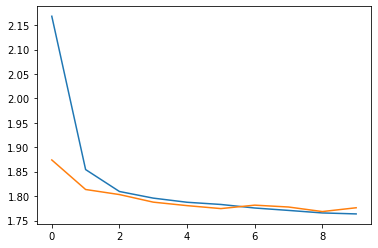

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [SUMMARIZE_AFTER*i for i in range(len(train_loss))]
plt.plot(x, train_loss)
plt.plot(x, validation_loss)
plt.show()